In [1]:
!pip install -q scikit-learn matplotlib pandas transformers scipy


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


Total number of unique learning rates in the LR column: 25
Number of unique learning rates after filtering: 25
Plot saved to 0_1000_dnd/layer_mad_over_epochs_with_train_loss_gradient.png


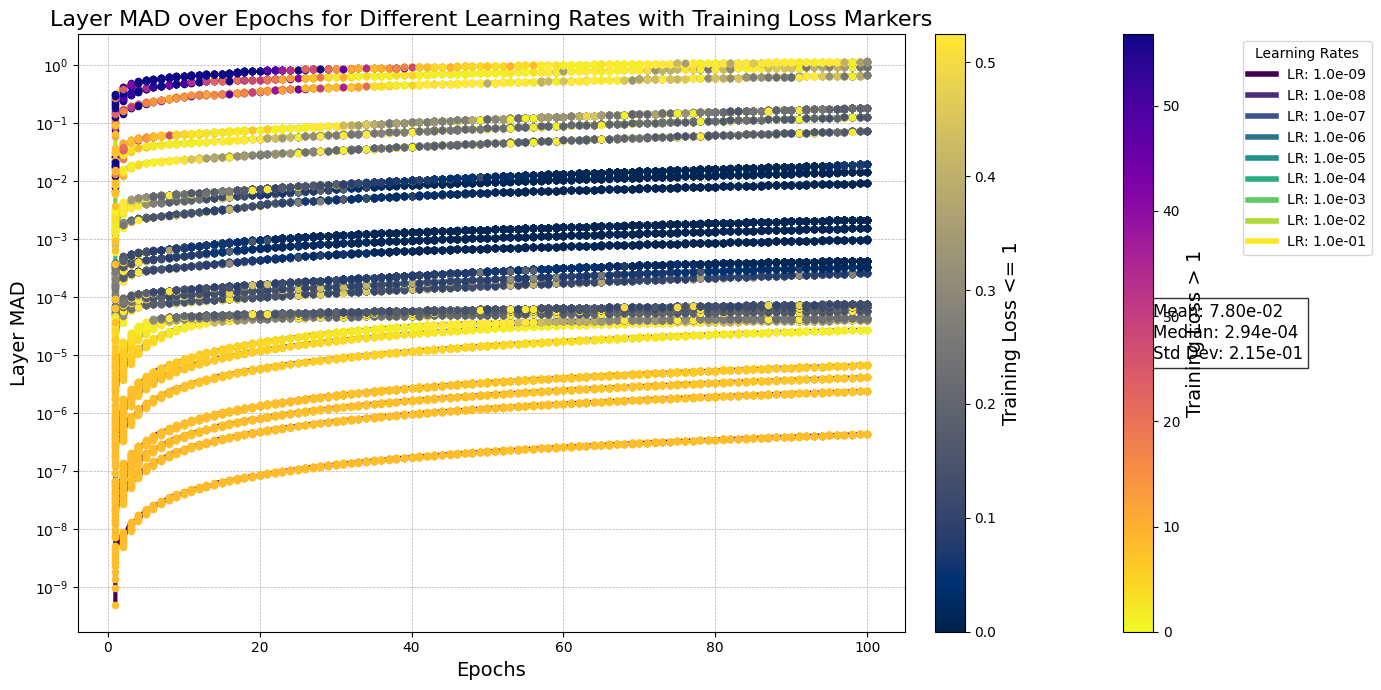

Plot saved to 0_1000_dnd/mean_layer_mad_vs_lr.png


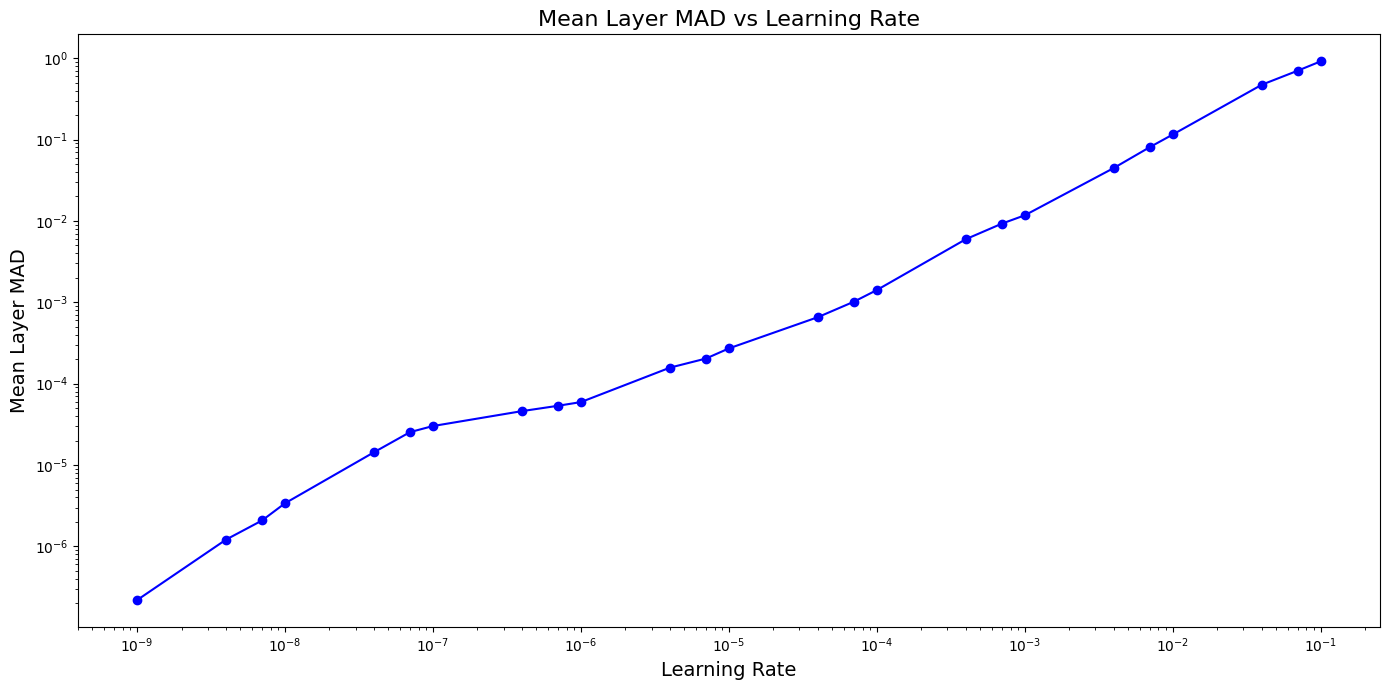

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

# Constants
EXPERIMENT = "0_1000_dnd"
MAIN_CSV_FILE_PATH = f"{EXPERIMENT}/0_1000_dnd.csv"
OUTPUT_FOLDER = f"{EXPERIMENT}/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
MAXIMUM_EPOCHS = 100  # Configuration value for the maximum epochs

# Function to filter learning rates
def filter_learning_rates(df):
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    return df

# Function to plot Layer MAD over epochs for all learning rates
def plot_layer_mad_over_epochs(csv_file_path, output_folder):
    df = pd.read_csv(csv_file_path)
    unique_lrs_total = len(df['LR'].unique())
    df = filter_learning_rates(df)
    unique_lrs_filtered = len(df['LR'].unique())
    
    print(f"Total number of unique learning rates in the LR column: {unique_lrs_total}")
    print(f"Number of unique learning rates after filtering: {unique_lrs_filtered}")
    
    learning_rates = sorted(df['LR'].unique())
    num_colors = len(learning_rates)
    lr_colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Separate data based on Train Loss
    df_above_1 = df[df['Train Loss'] > 1]
    df_below_1 = df[df['Train Loss'] <= 1]
    
    # Initialize vmin and vmax
    vmin_above, vmax_above = 0, 1
    vmin_below, vmax_below = 0, 1
    
    # Median and standard deviation for Training Loss above 1
    if not df_above_1.empty:
        median_above_1 = df_above_1['Train Loss'].median()
        std_above_1 = df_above_1['Train Loss'].std()
        vmin_above = max(0, median_above_1 - 2 * std_above_1)  # Ensure no negative values
        vmax_above = median_above_1 + 2 * std_above_1
    
    # Median and standard deviation for Training Loss below 1
    if not df_below_1.empty:
        median_below_1 = df_below_1['Train Loss'].median()
        std_below_1 = df_below_1['Train Loss'].std()
        vmin_below = max(0, median_below_1 - 2 * std_below_1)  # Ensure no negative values
        vmax_below = median_below_1 + 2 * std_below_1
    
    norm_above = mcolors.Normalize(vmin=vmin_above, vmax=vmax_above)
    norm_below = mcolors.Normalize(vmin=vmin_below, vmax=vmax_below)
    
    # Use distinct colormaps to avoid overlap
    cmap_above = plt.cm.plasma.reversed()
    cmap_below = plt.cm.cividis
    
    for lr, color in zip(learning_rates, lr_colors):
        lr_df = df[df['LR'] == lr]
        if lr_df.empty:
            continue
        lr_df = lr_df.sort_values(by='Epoch')  # Ensure the data is sorted by epoch
        
        # Adding gradient color markers for Training Loss
        for _, row in lr_df.iterrows():
            if row['Train Loss'] > 1:
                train_loss_color = cmap_above(np.clip(norm_above(row['Train Loss']), 0, 1))
            else:
                train_loss_color = cmap_below(np.clip(norm_below(row['Train Loss']), 0, 1))
            ax.scatter(row['Epoch'], row['Overall MAD'], color=train_loss_color, s=20, zorder=5)  # Smaller dots

        # Plot the line over the dots
        ax.plot(lr_df['Epoch'], lr_df['Overall MAD'], label=f'LR: {lr:.1e}', color=color, linewidth=3, zorder=4)  # Thicker lines
    
    # Calculate and print statistical metrics
    mean_final_mad = df['Overall MAD'].mean()
    median_final_mad = df['Overall MAD'].median()
    std_final_mad = df['Overall MAD'].std()

    stats_text = f'Mean: {mean_final_mad:.2e}\nMedian: {median_final_mad:.2e}\nStd Dev: {std_final_mad:.2e}'
    plt.text(1.3, 0.5, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

    # Select learning rates for the legend, one for each power of ten
    learning_rates_array = np.array(learning_rates)
    powers_of_ten = [10**i for i in range(int(np.log10(min(learning_rates))), int(np.log10(max(learning_rates))) + 1)]
    legend_indices = [np.abs(learning_rates_array - lr).argmin() for lr in powers_of_ten]
    handles = [plt.Line2D([0], [0], color=lr_colors[i], lw=4) for i in legend_indices]
    labels = [f'LR: {learning_rates[i]:.1e}' for i in legend_indices]
    
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Layer MAD', fontsize=14)
    ax.set_title('Layer MAD over Epochs for Different Learning Rates with Training Loss Markers', fontsize=16)
    ax.legend(handles, labels, title='Learning Rates', bbox_to_anchor=(1.4, 1), loc='upper left')  # Move legend more to the right
    ax.set_yscale('log')
    
    # Add grid lines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Reduce number of horizontal grid lines
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax.yaxis.set_minor_locator(ticker.NullLocator())

    # Add a colorbar for the Training Loss gradient
    sm_above = plt.cm.ScalarMappable(cmap=cmap_above, norm=norm_above)
    sm_above.set_array([])
    cbar_above = plt.colorbar(sm_above, ax=ax, orientation='vertical', pad=0.03)
    cbar_above.set_label('Training Loss > 1', fontsize=14)
    
    sm_below = plt.cm.ScalarMappable(cmap=cmap_below, norm=norm_below)
    sm_below.set_array([])
    cbar_below = plt.colorbar(sm_below, ax=ax, orientation='vertical', pad=0.03)
    cbar_below.set_label('Training Loss <= 1', fontsize=14)
    
    plt.tight_layout()
    plot_path = os.path.join(output_folder, 'layer_mad_over_epochs_with_train_loss_gradient.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Plot saved to {plot_path}')
    plt.show()

def plot_mad_vs_lr(csv_file_path, output_folder):
    df = pd.read_csv(csv_file_path)
    df = filter_learning_rates(df)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    mean_mad_per_lr = df.groupby('LR')['Overall MAD'].mean().reset_index()
    
    ax.plot(mean_mad_per_lr['LR'], mean_mad_per_lr['Overall MAD'], marker='o', linestyle='-', color='b')
    
    ax.set_xlabel('Learning Rate', fontsize=14)
    ax.set_ylabel('Mean Layer MAD', fontsize=14)
    ax.set_title('Mean Layer MAD vs Learning Rate', fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    plt.tight_layout()
    plot_path = os.path.join(output_folder, 'mean_layer_mad_vs_lr.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Plot saved to {plot_path}')
    plt.show()

def main():
    plot_layer_mad_over_epochs(MAIN_CSV_FILE_PATH, OUTPUT_FOLDER)
    plot_mad_vs_lr(MAIN_CSV_FILE_PATH, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

# Constants
EXPERIMENT = "quick_pareto_500"
MAIN_CSV_FILE_PATH = f"{EXPERIMENT}/lr_dependency_results_scaled.csv"
OUTPUT_FOLDER = f"{EXPERIMENT}/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Function to filter learning rates
def filter_learning_rates(df):
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    return df

# Function to plot Layer MAD over epochs for all learning rates
def plot_layer_mad_over_epochs(csv_file_path, output_folder):
    df = pd.read_csv(csv_file_path)
    unique_lrs_total = len(df['LR'].unique())
    df = filter_learning_rates(df)
    unique_lrs_filtered = len(df['LR'].unique())
    
    print(f"Total number of unique learning rates in the LR column: {unique_lrs_total}")
    print(f"Number of unique learning rates after filtering: {unique_lrs_filtered}")
    
    learning_rates = sorted(df['LR'].unique())
    num_colors = len(learning_rates)
    lr_colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Median and standard deviation for Training Loss for the color gradient
    median_train_loss = df['Train Loss'].median()
    std_train_loss = df['Train Loss'].std()
    vmin = median_train_loss - 2 * std_train_loss
    vmax = median_train_loss + 2 * std_train_loss
    
    train_loss_norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    train_loss_cmap = plt.cm.plasma

    # Plot heatmap-like background based on learning rates
    for lr, color in zip(learning_rates, lr_colors):
        lr_df = df[df['LR'] == lr]
        if lr_df.empty:
            continue
        lr_df = lr_df.sort_values(by='Epoch')
        for _, row in lr_df.iterrows():
            ax.axvspan(row['Epoch'] - 0.5, row['Epoch'] + 0.5, color=color, alpha=0.2)

    # Adding gradient color markers for Training Loss
    for lr, color in zip(learning_rates, lr_colors):
        lr_df = df[df['LR'] == lr]
        if lr_df.empty:
            continue
        lr_df = lr_df.sort_values(by='Epoch')
        for _, row in lr_df.iterrows():
            train_loss_color = train_loss_cmap(np.clip(train_loss_norm(row['Train Loss']), 0, 1))
            ax.scatter(row['Epoch'], row['Overall MAD'], color=train_loss_color, s=70, zorder=5)

    # Select learning rates for the legend, one for each power of ten
    learning_rates_array = np.array(learning_rates)
    powers_of_ten = [10**i for i in range(int(np.log10(min(learning_rates))), int(np.log10(max(learning_rates))) + 1)]
    legend_indices = [np.abs(learning_rates_array - lr).argmin() for lr in powers_of_ten]
    handles = [plt.Line2D([0], [0], color=lr_colors[i], lw=4) for i in legend_indices]
    labels = [f'LR: {learning_rates[i]:.1e}' for i in legend_indices]
    
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Layer MAD', fontsize=14)
    ax.set_title('Layer MAD over Epochs for Different Learning Rates with Training Loss Markers', fontsize=16)
    ax.legend(handles, labels, title='Learning Rates', bbox_to_anchor=(1.2, 1), loc='upper left')  # Move legend more to the right
    ax.set_yscale('log')
    
    # Add grid lines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Reduce number of horizontal grid lines
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax.yaxis.set_minor_locator(ticker.NullLocator())

    # Add a colorbar for the Training Loss gradient
    sm = plt.cm.ScalarMappable(cmap=train_loss_cmap, norm=train_loss_norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.03)
    cbar.set_label('Training Loss', fontsize=14)
    
    plt.tight_layout()
    plot_path = os.path.join(output_folder, 'layer_mad_over_epochs_with_train_loss_gradient.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Plot saved to {plot_path}')
    plt.show()

def main():
    plot_layer_mad_over_epochs(MAIN_CSV_FILE_PATH, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Constants
EXPERIMENT = "10_epochs"
MAIN_CSV_FILE_PATH = f"{EXPERIMENT}/lr_dependency_results_scaled.csv"
OUTPUT_FOLDER = f"{EXPERIMENT}/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Function to filter learning rates
def filter_learning_rates(df):
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    return df

# Function to plot Layer MAD over epochs for all learning rates
def plot_layer_mad_over_epochs(csv_file_path, output_folder):
    df = pd.read_csv(csv_file_path)
    unique_lrs_total = len(df['LR'].unique())
    df = filter_learning_rates(df)
    unique_lrs_filtered = len(df['LR'].unique())
    
    print(f"Total number of unique learning rates in the LR column: {unique_lrs_total}")
    print(f"Number of unique learning rates after filtering: {unique_lrs_filtered}")
    
    learning_rates = sorted(df['LR'].unique())
    num_colors = len(learning_rates)
    lr_colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Min and max for Avg Correct Count for the second gradient
    min_avg_correct_count = df['Avg Correct Count'].min()
    max_avg_correct_count = df['Avg Correct Count'].max()
    
    if min_avg_correct_count <= 0:
        min_avg_correct_count = 1e-2  # Set a small positive value for log scale to work correctly
    
    avg_correct_norm = mcolors.LogNorm(vmin=min_avg_correct_count, vmax=max_avg_correct_count)
    avg_correct_cmap = plt.cm.plasma
    
    for lr, color in zip(learning_rates, lr_colors):
        lr_df = df[df['LR'] == lr]
        if lr_df.empty:
            continue
        lr_df = lr_df.sort_values(by='Epoch')  # Ensure the data is sorted by epoch
        ax.plot(lr_df['Epoch'], lr_df['Overall MAD'], label=f'LR: {lr:.1e}', color=color)
        
        # Adding gradient color markers for Avg Correct Count
        for _, row in lr_df.iterrows():
            avg_correct_color = avg_correct_cmap(avg_correct_norm(row['Avg Correct Count']))
            ax.scatter(row['Epoch'], row['Overall MAD'], color=avg_correct_color, s=50, zorder=5)  # Smaller dots
    
    # Select learning rates for the legend, one for each power of ten
    learning_rates_array = np.array(learning_rates)
    powers_of_ten = [10**i for i in range(int(np.log10(min(learning_rates))), int(np.log10(max(learning_rates))) + 1)]
    legend_indices = [np.abs(learning_rates_array - lr).argmin() for lr in powers_of_ten]
    handles = [plt.Line2D([0], [0], color=lr_colors[i], lw=4) for i in legend_indices]
    labels = [f'LR: {learning_rates[i]:.1e}' for i in legend_indices]
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Layer MAD')
    ax.set_title('Layer MAD over Epochs for Different Learning Rates with Correct Count Markers')
    ax.legend(handles, labels, title='Learning Rates', bbox_to_anchor=(1.15, 1), loc='upper left')  # Move legend more to the right
    ax.set_yscale('log')
    
    # Set y-axis limits
    ax.set_ylim(1e-9, 1e-2)
    
    # Add a colorbar for the Avg Correct Count gradient
    sm = plt.cm.ScalarMappable(cmap=avg_correct_cmap, norm=avg_correct_norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Avg Correct Count')
    
    plt.tight_layout()
    plot_path = os.path.join(output_folder, 'layer_mad_over_epochs_with_markers_and_gradient.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Plot saved to {plot_path}')
    plt.show()

def main():
    plot_layer_mad_over_epochs(MAIN_CSV_FILE_PATH, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Constants
EXPERIMENT = "fixed_1e7_2"
MAIN_CSV_FILE_PATH = f"{EXPERIMENT}/lr_dependency_results_scaled.csv"
OUTPUT_FOLDER = f"{EXPERIMENT}/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Function to filter learning rates
def filter_learning_rates(df):
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    return df

# Function to plot Layer MAD over epochs for all learning rates
def plot_layer_mad_over_epochs(csv_file_path, output_folder):
    df = pd.read_csv(csv_file_path)
    unique_lrs_total = len(df['LR'].unique())
    df = filter_learning_rates(df)
    unique_lrs_filtered = len(df['LR'].unique())
    
    print(f"Total number of unique learning rates in the LR column: {unique_lrs_total}")
    print(f"Number of unique learning rates after filtering: {unique_lrs_filtered}")
    
    learning_rates = sorted(df['LR'].unique())
    num_colors = len(learning_rates)
    colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for lr, color in zip(learning_rates, colors):
        lr_df = df[df['LR'] == lr]
        if lr_df.empty:
            continue
        ax.plot(lr_df['Epoch'], lr_df['Overall MAD'], label=f'LR: {lr:.1e}', color=color)
    
    # Select learning rates for the legend, one for each power of ten
    learning_rates_array = np.array(learning_rates)
    powers_of_ten = [10**i for i in range(int(np.log10(min(learning_rates))), int(np.log10(max(learning_rates))) + 1)]
    legend_indices = [np.abs(learning_rates_array - lr).argmin() for lr in powers_of_ten]
    handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in legend_indices]
    labels = [f'LR: {learning_rates[i]:.1e}' for i in legend_indices]
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Layer MAD')
    ax.set_title('Layer MAD over Epochs for Different Learning Rates')
    ax.legend(handles, labels, title='Learning Rates', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_yscale('log')
    
    # Set y-axis limits
    ax.set_ylim(1e-9, 1e-5)
    
    plt.tight_layout()
    plot_path = os.path.join(output_folder, 'layer_mad_over_epochs.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Plot saved to {plot_path}')
    plt.show()

def main():
    plot_layer_mad_over_epochs(MAIN_CSV_FILE_PATH, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Constants
EXPERIMENT = "fixed_1e7_2"
MAIN_CSV_FILE_PATH = f"{EXPERIMENT}/lr_dependency_results_scaled.csv"
OUTPUT_FOLDER = f"{EXPERIMENT}/"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Function to filter learning rates
def filter_learning_rates(df):
    df = df[pd.to_numeric(df['LR'], errors='coerce').notnull()]
    df['LR'] = df['LR'].astype(float)
    return df

# Function to plot Gradient MAD over epochs for all learning rates
def plot_gradient_mad_over_epochs(csv_file_path, output_folder):
    df = pd.read_csv(csv_file_path)
    unique_lrs_total = len(df['LR'].unique())
    df = filter_learning_rates(df)
    unique_lrs_filtered = len(df['LR'].unique())
    
    print(f"Total number of unique learning rates in the LR column: {unique_lrs_total}")
    print(f"Number of unique learning rates after filtering: {unique_lrs_filtered}")
    
    learning_rates = sorted(df['LR'].unique())
    num_colors = len(learning_rates)
    colors = plt.cm.viridis(np.linspace(0, 1, num_colors))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for lr, color in zip(learning_rates, colors):
        lr_df = df[df['LR'] == lr]
        if lr_df.empty:
            continue
        ax.plot(lr_df['Epoch'], lr_df['Overall Gradient MAD'], label=f'LR: {lr:.1e}', color=color)
    
    # Select learning rates for the legend, one for each power of ten
    learning_rates_array = np.array(learning_rates)
    powers_of_ten = [10**i for i in range(int(np.log10(min(learning_rates))), int(np.log10(max(learning_rates))) + 1)]
    legend_indices = [np.abs(learning_rates_array - lr).argmin() for lr in powers_of_ten]
    handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in legend_indices]
    labels = [f'LR: {learning_rates[i]:.1e}' for i in legend_indices]
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Gradient MAD')
    ax.set_title('Gradient MAD over Epochs for Different Learning Rates')
    ax.legend(handles, labels, title='Learning Rates', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_yscale('log')
    
    # Set y-axis limits
    ax.set_ylim(1e-6, 1)
    
    plt.tight_layout()
    plot_path = os.path.join(output_folder, 'gradient_mad_over_epochs.png')
    plt.savefig(plot_path, bbox_inches='tight')
    print(f'Plot saved to {plot_path}')
    plt.show()

def main():
    plot_gradient_mad_over_epochs(MAIN_CSV_FILE_PATH, OUTPUT_FOLDER)

if __name__ == "__main__":
    main()
